In [175]:
import sbi
from sbi import utils as utils
from sbi.inference.base import infer
import torch as tr
import torch.distributions as distrib
import numpy as np

import matplotlib.pyplot as plt

## SBI

Its a package that implements methods for simulation based inference e.g. SNPE, SNLE and SNRE.

In [179]:
num_dim = 3
prior = utils.BoxUniform(low=-2*tr.ones(num_dim), high=2*tr.ones(num_dim))

def simulator(parameter_set):
    return 1.0 + parameter_set + tr.randn(parameter_set.shape) * 0.1

In [180]:
posterior = infer(simulator, prior, method='SNPE', num_simulations=1000)

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:00<00:00, 27767.29it/s]
Neural network successfully converged after 125 epochs.


In [183]:
observation = tr.zeros(3)

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 15861.06it/s]


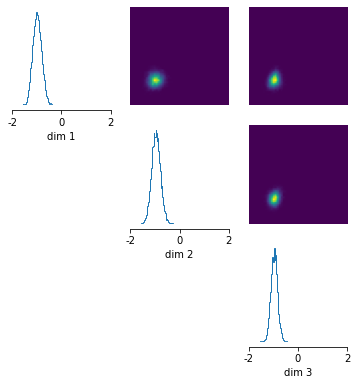

In [184]:
samples = posterior.sample((10000,), x=observation)
log_probability = posterior.log_prob(samples, x=observation)
_ = utils.pairplot(samples, limits=[[-2,2],[-2,2],[-2,2]], fig_size=(6,6))

### 1) Lotka Voltera inference

The Lotka Voltera model is a stochastic model that describe the time evolution of a predator prey population. Let $X$ be the number of predator and $Y$ be the population of preys then
- A predator is born with rate $\theta_1$ XY, increasing X by one
- A predator die with rate $\theta_2 X$, decreasing $X$ by one 
- A prey may be born with rate $\theta_3Y$, increasing Y by one 
- A prey may be eaten by a predator with rate $\theta_4XY, deceaing Y by one.

We can simulate the process as following:
- Draw the time to next event from an exponential distribution with rate eqaut to $\theta_1 XY + \theta_2 X + \theta_3 Y + \theta_4 XY$
- Select some event proportional to the rates $(\theta_1, \theta_2, \theta_3, \theta_4)$
- Simulate the event and repeat

In [15]:
def simulator(thetas, X_0 = 50, Y_0 = 100, t_max = 15, device="cpu"):
    N, _ = thetas.shape
    i_max = int(t_max/0.2)
    tot_events = tr.tensor([1,-1,1,-1]).to(device)
    thetas = thetas.to(device)
    t = tr.zeros(N,i_max).to(device)
    X = tr.zeros(N,i_max).to(device)
    Y = tr.zeros(N,i_max).to(device)
    rates = tr.zeros(N, 4).to(device)
    X[:,0] = X_0 
    Y[:,0] = Y_0
    for i in range(1,i_max):
        X[:,i] = X[:,i-1]
        Y[:,i] = Y[:,i-1]
        t[:,i] = t[:,i-1]
        while (t[:,i] < 0.2*i).any():
            #Mask out finished
            t_mask = tr.logical_and(t[:,i] < 0.2*i, X[:,i] + Y[:,i] != 0)
            if not t_mask.any(): break
            rates[t_mask,0] = thetas[t_mask,0]*X[t_mask,i]*Y[t_mask,i]
            rates[t_mask,1] = thetas[t_mask,1]*X[t_mask,i]
            rates[t_mask,2] = thetas[t_mask,2]*Y[t_mask,i]
            rates[t_mask,3] = thetas[t_mask,3]*X[t_mask,i]*Y[t_mask,i]
            dt = distrib.Exponential(rates[t_mask].sum(1)).sample()
            event = distrib.Categorical(logits=rates.log()-rates.sum(1).log().reshape(-1,1)).sample()
            t[t_mask,i] += dt
            # X events
            X_mask = tr.logical_and(event < 2, t_mask)
            if X_mask.any():
                X[X_mask, i] += tot_events[event[X_mask]]
            # Y events
            Y_mask = tr.logical_and(event >= 2, t_mask)
            if Y_mask.any():
                Y[Y_mask, i] += tot_events[event[Y_mask]]
    return X,Y,t

In [169]:
thetas = tr.tensor([0.01, 0.5, 0.9, 0.01]).repeat(10).reshape(10,-1)

In [170]:
X,Y,t = simulator(thetas, X_0 = 50, Y_0 = 100, t_max=15., device="cpu")

Simulating the model is not cheap, hence we have to rely on an efficient inference procedure. Further each time series is high dimensional, we have 3 tensors of size 151 containing the predator and prey populations as well as the time points.

Thus we will reduce the data to summary statistics containing the mean of each time series, the log variance of each time series and the auto and cross-correlaton.

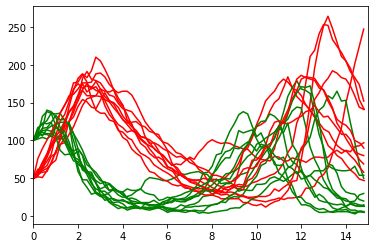

In [171]:
for i in range(10):
    plt.plot(t[i,:],X[i,:], "red")
    plt.plot(t[i,:],Y[i,:], "green")
    plt.xlim(0,15)

In [172]:
def encode(X,Y):
    mean_X = X.mean(1)
    mean_Y = Y.mean(1)
    var_X = X.var(1).log()
    var_Y = Y.var(1).log()
    autocorr_X = tr.zeros(X.size(0))
    autocorr_Y = tr.zeros(Y.size(0))
    cross_corr_XY = tr.zeros(X.size(0))
    for i,(x,y) in enumerate(zip(X,Y)):
        autocorr_X[i] = tr.tensor(np.correlate(x.numpy(),x.numpy()))
        autocorr_Y[i] = tr.tensor(np.correlate(y.numpy(),y.numpy()))
        cross_corr_XY[i] = tr.tensor(np.correlate(y.numpy(),x.numpy()))
    phi_XY = tr.vstack([mean_X,mean_Y, var_X,var_Y, autocorr_X, autocorr_Y, cross_corr_XY]).T
    return phi_XY

Lets consider as prior 
$$ p(\log \theta) \propto \prod_{i=1}^4 U(\log\theta_i | -5,2)$$

In [42]:
prior = distrib.Uniform(tr.ones(4)*-5., tr.ones(4)*2)
# Test dataset
def sample_phis(N, dist=prior):
    logthetas = dist.sample_n(N).reshape(N,-1)
    phis = tr.zeros(N,7)
    for i in range(len(logthetas)):
        X,Y,t = simulator(logthetas[i].exp().reshape(1,-1))
        phis[i] = encode(X,Y)
    return phis, logthetas

NameError: name 'torch' is not defined

In [22]:
# Get batch samples for computing normalizing statistics: Takes long...
phis, logthetas = sample_phis(10)
# Statistics for normalization
MU = phis.mean(0)
VAR = phis.var(0)

KeyboardInterrupt: 

In [ ]:
def normalize_phi(phi):
    return (phi-MU)/tr.sqrt(VAR)

In [ ]:
phis_normed = normalize_phi(phis)
train_data = []
for i in range(len(phis_normed)):
   train_data.append([phis_normed[i], logthetas[i]])
data = DataLoader(train_data, batch_size=200,shuffle=True)